In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.utils.data as Data
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import time

In [16]:
# Load the EMNIST dataset

train_data = torchvision.datasets.EMNIST(
    root='data',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True,
    split='letters'
)

test_data = torchvision.datasets.EMNIST(
    root='data',
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=False,
    split='letters'     
)

x_train = (train_data.data / 255).view(-1, 28*28)
y_train = train_data.targets - 1

In [3]:
class Linear:
    
    def __init__(self, in_features, out_features, bias=True, gain=1):
        self.weight = torch.randn((in_features, out_features)) * gain/in_features**0.5
        self.bias = torch.zeros(out_features) if bias else None
    
    def __call__(self, input):
        self.out = input @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [4]:
class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
  
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
  
    def parameters(self):
        return [self.gamma, self.beta]

In [5]:
class Tanh:
    
    def __call__(self, input):
        self.out = torch.tanh(input)
        return self.out
    
    def parameters(self):
        return []

In [6]:
class Sequential:
    
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, input):
        for layer in self.layers:
            input = layer(input)
        self.out = input
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [7]:
n_hidden = 100

model = Sequential([
    Linear(28*28, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, 26, bias=True),
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parametes = model.parameters()
print(sum(p.nelement() for p in parametes))
for p in parametes:
    p.requires_grad = True

81226


In [20]:
# Build the batch

batch_size = 32
loss_record = []
max_steps =  300000
# learning_rates = 10**torch.linspace(-3, 0, max_steps)

for _ in range(max_steps):

    # Minibatch construct
    selected_index = torch.randint(0, x_train.shape[0], (batch_size,))
    x_batch, y_batch = x_train[selected_index], y_train[selected_index]

    # Forward pass
    logits = model(x_batch)
    loss = F.cross_entropy(logits, y_batch)

    # Backward pass
    for p in parametes:
        p.grad = None
    loss.backward()

    # Update
    learning_rate = 10**-1.25 # if _ < max_steps / 2 else 10**-2
    for p in parametes:
        p.data -= learning_rate * p.grad

    # Track status
    loss_record.append(loss.log10().item())

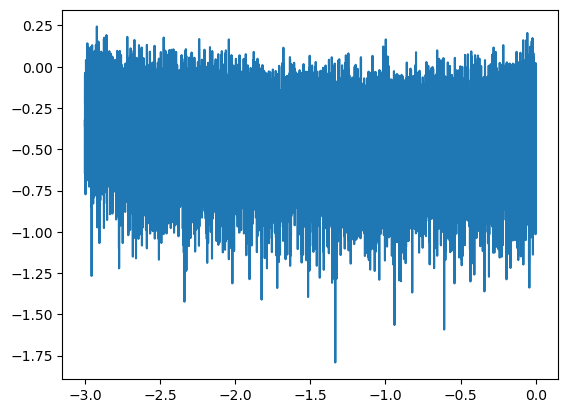

In [13]:
# plt.plot(learning_rates.log10(), loss_record)

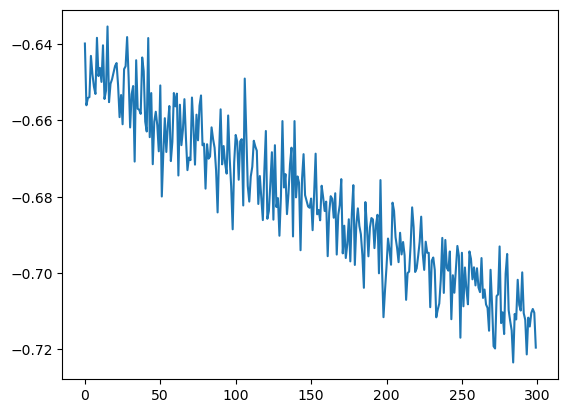

In [21]:
plt.plot(torch.tensor(loss_record).view(-1, 1000).mean(1))

Image Label: l
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan]])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan]])


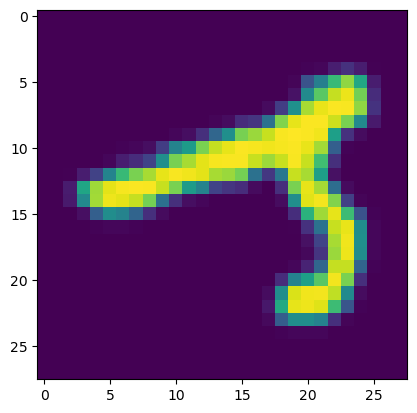

In [39]:
# Test on a certain image

img, label = x_train[206], y_train[206]
print("Image Label: " + str(chr(label+97)))
plt.imshow(img.reshape((28,28)))

for layer in model.layers:
    layer.training = False

with torch.no_grad():
    img = img.view(1, 28*28)
    logits = model(img)
    prob = F.softmax(logits, dim=0)

print(logits)

In [40]:
x_train.shape

torch.Size([124800, 784])